In [18]:
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tqdm
import svjconesizestudy
import math, sys
from math import pi
import logging

In [19]:
%matplotlib inline
mpl.rcParams['legend.fontsize'] = 14
import qondor
qondor.logger.setLevel(logging.WARNING)
logging.getLogger('subprocess').setLevel(logging.WARNING)
qondor.seutils.set_default_mgm('root://cmseos.fnal.gov')

In [114]:
# rootdir = (
#     'root://cmseos.fnal.gov/'
#     '/store/user/klijnsma/semivis/SaveSubstructure/'
#     # 'Mar09_35067218_64110319_2020-01-27_GEN_SVJ_s_2017_mZp250_mDQ10_rinv1em05_aD0p23'
#     # 'Mar23_s-channel_mMed-250_mDark-20_rinv-0_alpha-peak_HT400_13TeV-madgraphMLM-pythia8'
#     'Mar30_mMed-450_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8'
#     )

rootfile = 'particlehierarchy_numEvent300.root'
rootdir = 'root://cmseos.fnal.gov//store/user/klijnsma/semivis/zprimedecay/Apr01_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8'

class Factory(svjconesizestudy.EventFactoryDir):
    
    def __init__(self, *args, **kwargs):
        super(Factory, self).__init__(*args, **kwargs)
        self.do_progress_bar = True
    
    def __iter__(self):
        if self.do_progress_bar:
            tqdm.tqdm._instances.clear()
            qondor.logger.setLevel(logging.WARNING)
            with tqdm.tqdm(total=len(self), file=sys.stdout) as pbar:
                for i, event in enumerate(super(Factory, self).__iter__()):
                    pbar.update(1)
                    # pbar.set_description('processed: %d' % (1 + i))
                    yield event
            qondor.logger.setLevel(logging.INFO)
        else:
            for i in super(Factory, self).__iter__():
                yield i
        
    def progress_bar(self, flag=True):
        self.do_progress_bar = flag

test_factory = Factory.from_sedir(rootdir, 100)

[qondor| WARNING|2020-04-03 17:02:06|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/semivis/zprimedecay/Apr01_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8
[qondor|    INFO|2020-04-03 17:02:06|utils]: Command exited with status 0 - all good


# Testing

In [115]:
event = test_factory.get(2)
# event = svjconesizestudy.EventFactoryDir([rootfile]).get(2)
event

<ROOT.TTree object ("Events") at 0x1758adb0>

In [116]:
# pdgids = []
# for p in event.iter_genparticlesforjets():
#     pdgids.append(abs(p.pdgId()))
# print np.unique(pdgids)

# dark_pdgids = []
# for p in event.iter_dmparticles():
#     dark_pdgids.append(abs(p.pdgId()))
# print np.unique(dark_pdgids)

# Heatmap

[qondor| WARNING|2020-04-03 18:59:03|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/semivis/zprimedecay/Apr01_mMed-250_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8
[qondor|    INFO|2020-04-03 18:59:03|utils]: Command exited with status 0 - all good


100%|██████████| 34800/34800 [06:21<00:00, 91.15it/s] 


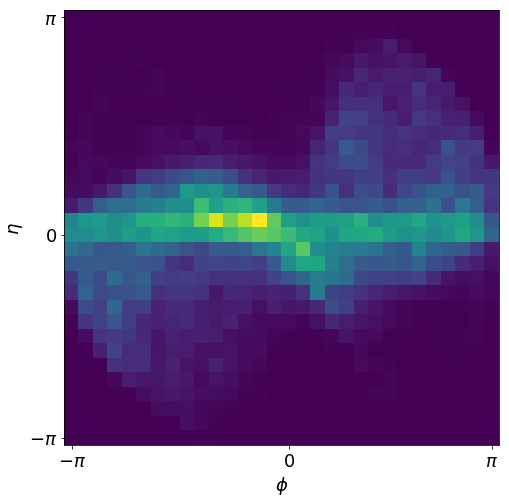

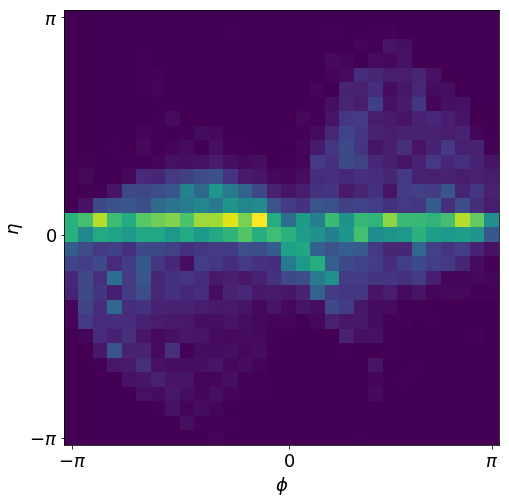

In [121]:
class Histogram2D(object):
    def __init__(self, xmin, xmax, nx, ymin, ymax, ny):
        self.xmin = xmin
        self.xmax = xmax
        self.nx = nx
        self.ymin = ymin
        self.ymax = ymax
        self.ny = ny
        self.x_binning = np.linspace(xmin, xmax, nx+1)
        self.x_centers = (self.x_binning[:-1] + self.x_binning[1:])/2.
        self.y_binning = np.linspace(ymin, ymax, ny+1)
        self.y_centers = (self.y_binning[:-1] + self.y_binning[1:])/2.
        self.z = np.zeros((nx,ny))
        
    @staticmethod
    def find_closest_index_in_array(x, array):
        if x < array[0]: return 0
        if x > array[-1]: return -1
        return (np.abs(array - x)).argmin()
        
    def find_bin_x(self, x):
        if x > self.x_binning[-1] or x < self.x_binning[0]: return -1
        return Histogram2D.find_closest_index_in_array(x, self.x_centers)

    def find_bin_y(self, y):
        if y > self.y_binning[-1] or y < self.y_binning[0]: return -1
        return Histogram2D.find_closest_index_in_array(y, self.y_centers)

    def add_point(self, x, y, z):
        ibin_x = self.find_bin_x(x)
        ibin_y = self.find_bin_y(y)
        if ibin_x == -1 or ibin_y == -1:
            return
        else:
            self.z[ibin_x, ibin_y] += z
            
    def add_points(self, xs, ys, zs):
        for x, y, z in zip(xs, ys, zs):
            self.add_point(x, y, z)


class Heatmap(object):
    def __init__(self):
        super(Heatmap, self).__init__()
        self.visible_particles = Histogram2D(-pi, pi, 30, -pi, pi, 30)
        self.dark_quarks = Histogram2D(-pi, pi, 30, -pi, pi, 30)
        self.rotate = True
    
    def get_deta_dphi(self, particles, p_source):
        eta_source = p_source.p4().Eta()
        phi_source = p_source.p4().Phi()
        deta_particles = np.zeros(len(particles))
        dphi_particles = np.zeros(len(particles))
        
        etas = np.array([p.p4().Eta() for p in particles])
        phis = np.array([p.p4().Phi() for p in particles])
        
        detas = etas - p_source.p4().Eta()
        dphis = etas - p_source.p4().Phi()
        
        dphis %= (2.*pi)
        dphis[dphis > pi] -= 2.*pi
        dphis[dphis < -pi] += 2.*pi        
        return detas, dphis
    
    def get_rot_angle(self, z):
        leading_dark_quark = list(sorted(z.finalDarkQuark, key=lambda q: q.p4().Pt()))[0]
        deta, dphi = self.get_deta_dphi([leading_dark_quark], z)
        deta = deta[0]
        dphi = dphi[0]
        theta = np.tanh(deta / dphi)
        return -theta # minus because rotate back

    def get_rot_mat(self, z):
        theta = self.get_rot_angle(z)
        return np.array([
            [ np.cos(theta), -np.sin(theta) ],
            [ np.sin(theta), np.cos(theta) ]
            ])
    
    def add_particles_to_histogram(self, particles, z_prime, histogram):
        deta, dphi = self.get_deta_dphi(particles, z_prime)
        if self.rotate:
            rotated = self.get_rot_mat(z_prime).dot(np.stack((dphi, deta)))
            dphi = rotated[0]
            deta = rotated[1]
        energies = [ p.energy() for p in particles ]
        histogram.add_points(dphi, deta, energies)
        
    def event_filter(self, event):
        if not(len(event.genparticlepluss())): return True
        z = event.genparticlepluss()[0]
        if z.p4().Eta() < 0.: return True
        if z.p4().Pt() < 200.: return True
        if not len(z.finalDarkQuark) == 2: return True
        return False
        
    def add_event(self, event):
        if self.event_filter(event): return
        z = event.genparticlepluss()[0]
        self.add_particles_to_histogram(z.finalVisibleProduct, z, self.visible_particles)
        self.add_particles_to_histogram(z.finalDarkQuark, z, self.dark_quarks)
        
    def add_events(self, factory):
        for event in factory:
            self.add_event(event)

    def debug_event(self, event):
        if self.event_filter(event): return
        z = event.genparticlepluss()[0]
        eta_z = z.p4().Eta()
        eta_darkquarks = [ p.p4().Eta() for p in z.finalDarkQuark ]
        eta_visible_particles = [ p.p4().Eta() for p in z.finalVisibleProduct ]
        
        print '-'*80
        print (
            'eta_z = {0}'
            .format(eta_z)
            )
        print (
            'eta_darkquarks = {0}'
            .format(eta_darkquarks)
            )
        print (
            'eta_visible_particles = {0} +- {1}'
            .format(np.mean(eta_visible_particles), np.std(eta_visible_particles))
            )
    
    def debug_events(self, factory):
        for event in factory:
            self.debug_event(event)
        
# factory = Factory.from_sedir(rootdir, 3)
factory = Factory.from_sedir(rootdir)
factory.progress_bar(True)

heatmaps = Heatmap()


# heatmaps.debug_events(factory)


heatmaps.add_events(factory)

def plot_hist(h):
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca()
    im = h.z.T # row, column <--> x, y ; so transpose to get row, column <--> y, x
    im = im[::-1] # make row 0 be down, and the last row up
    ax.imshow(im)
    ax.set_xlabel(r'$\phi$', fontsize=18)
    plt.xticks([0, int(h.nx/2.), h.nx-1], [r'$-\pi$', '0', r'$\pi$'], fontsize=18)
    ax.set_ylabel(r'$\eta$', fontsize=18)
    plt.yticks([0, int(h.ny/2.), h.ny-1], [r'$\pi$', '0', r'$-\pi$'], fontsize=18)

plot_hist(heatmaps.visible_particles)
plot_hist(heatmaps.dark_quarks)
    

# Plotting - GenParticlePluss

[qondor| WARNING|2020-04-03 16:24:22|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/semivis/zprimedecay/Apr01_mMed-450_mDark-20_rinv-0.3_alpha-peak_HT400_13TeV-madgraphMLM-pythia8
[qondor|    INFO|2020-04-03 16:24:22|utils]: Command exited with status 0 - all good


100%|██████████| 100/100 [00:01<00:00, 66.38it/s]


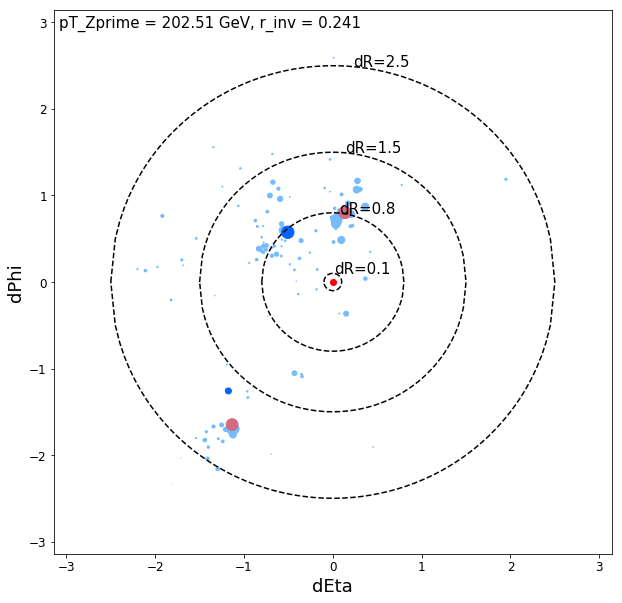

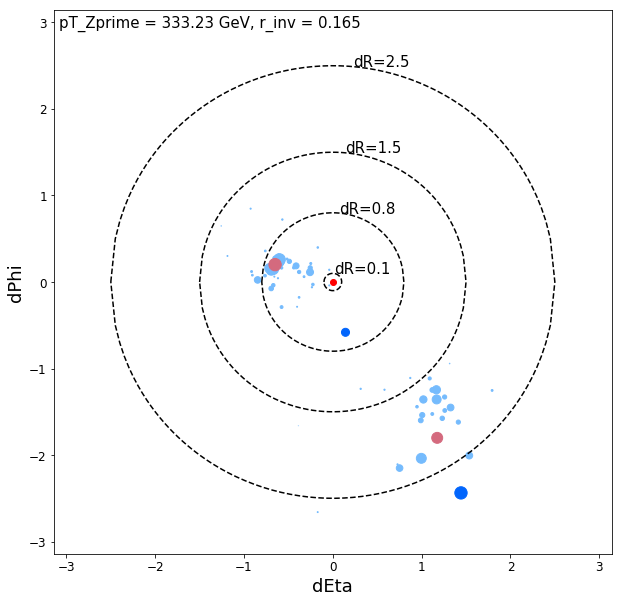

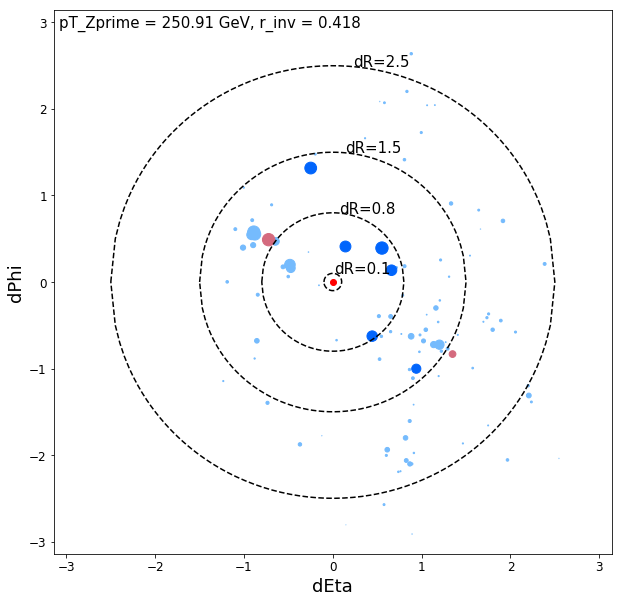

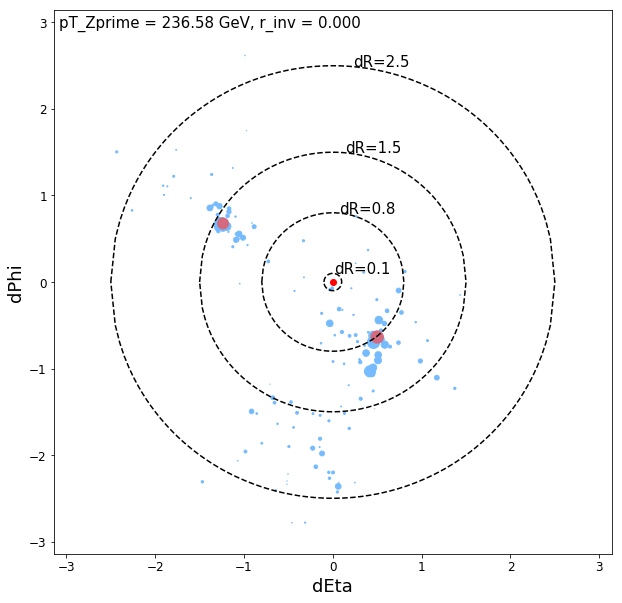

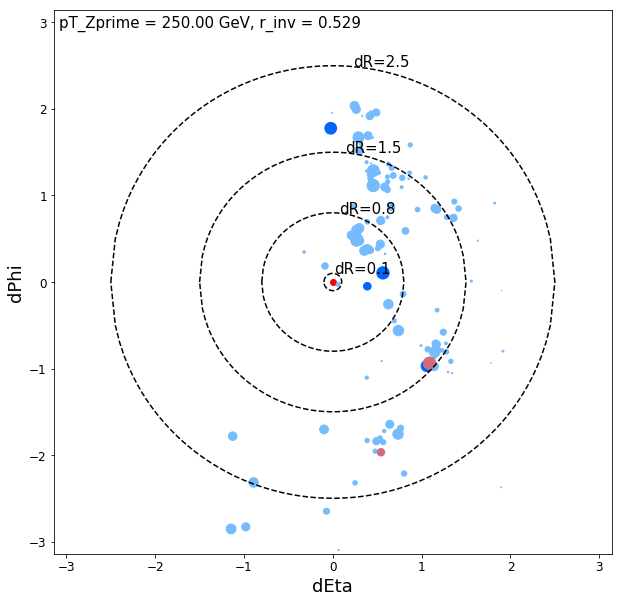

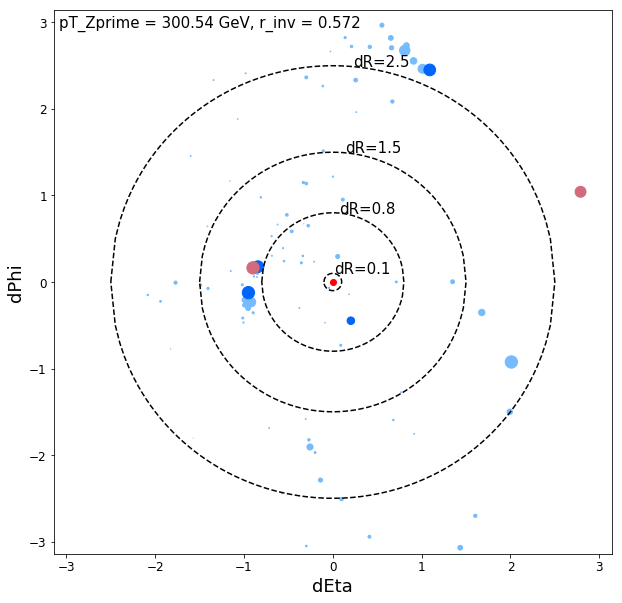

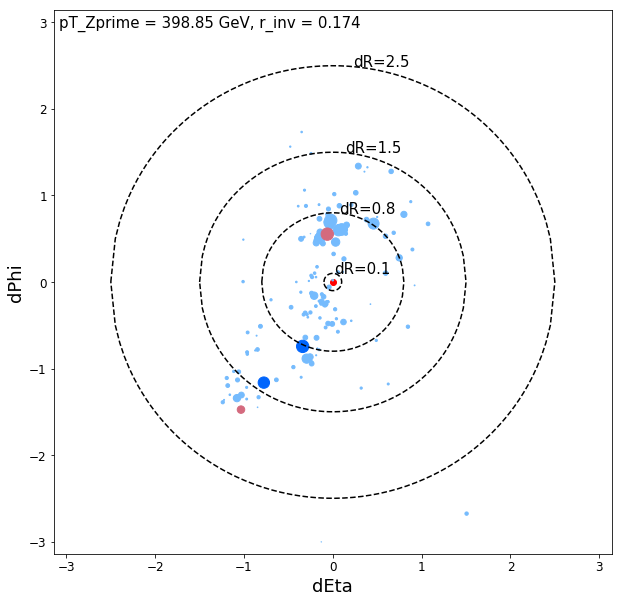

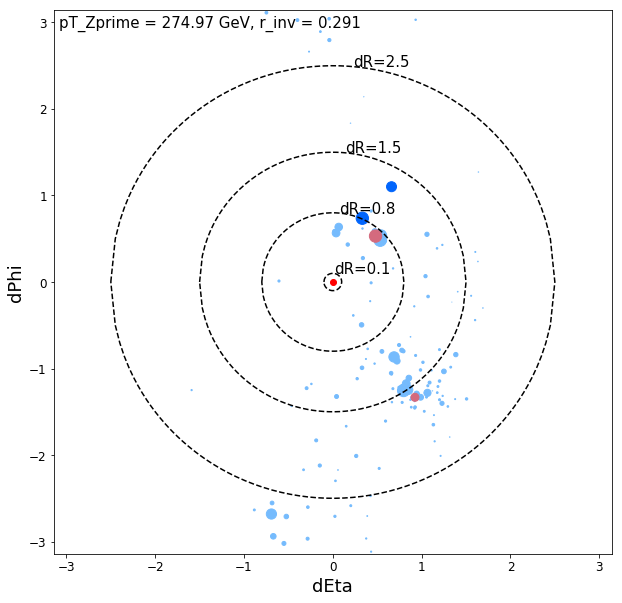

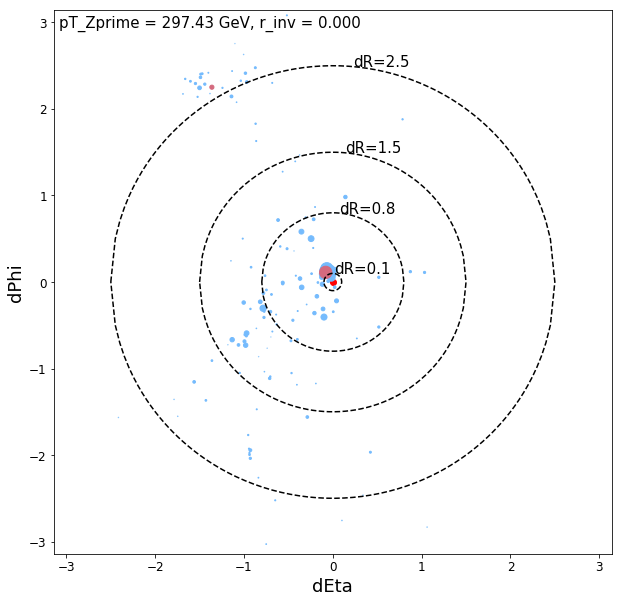

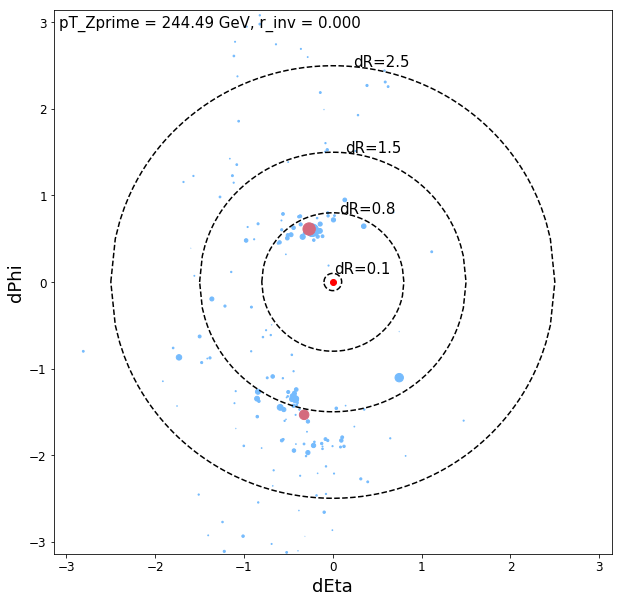

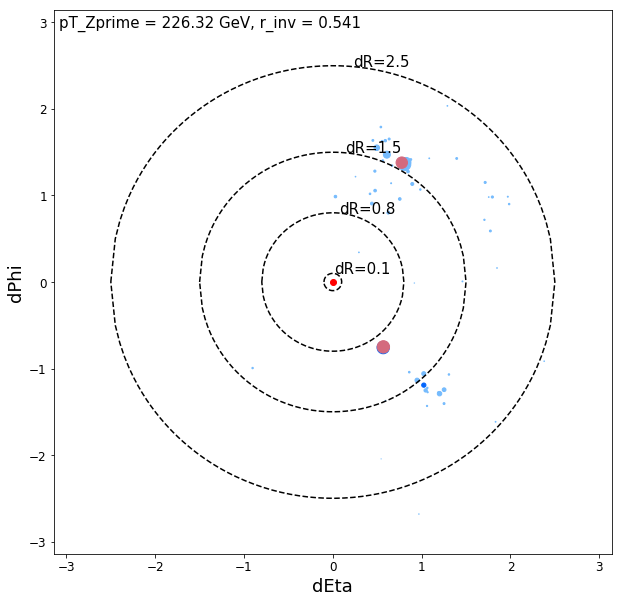

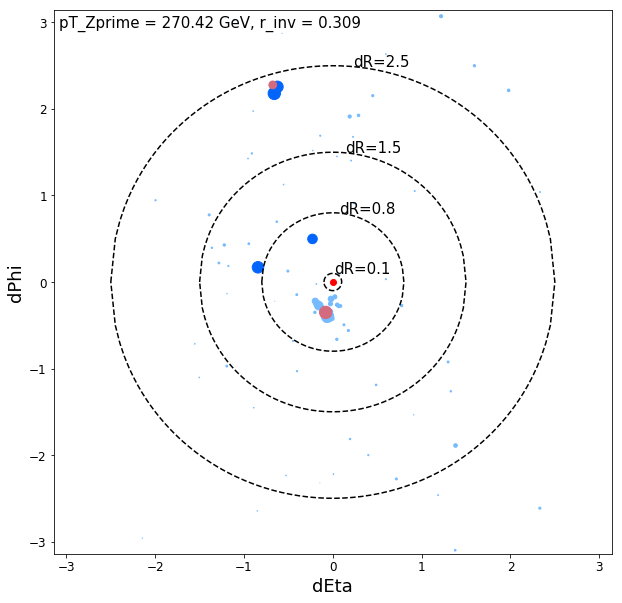

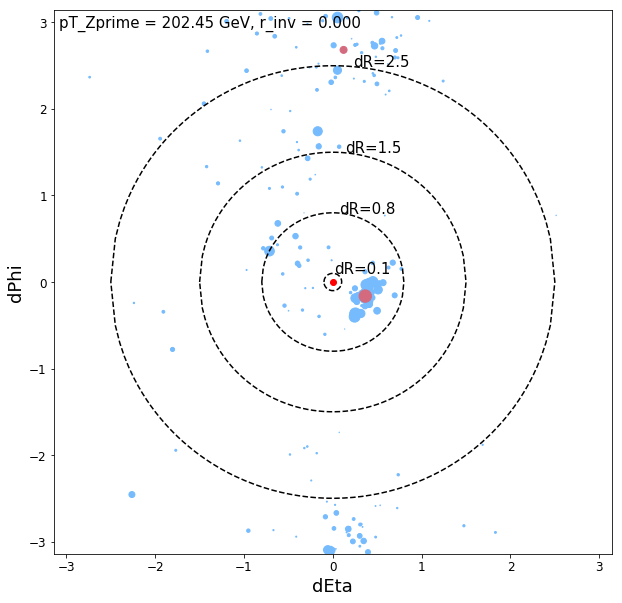

In [103]:
class PlotGenParticlePlus(object):
    def __init__(self, event):
        super(PlotGenParticlePlus, self).__init__()
        self.event = event
        self.zprime = self.event.genparticlepluss()[0]
        self.pt_z = self.zprime.p4().Pt()
        self.eta_z = self.zprime.p4().Eta()
        self.phi_z = self.zprime.p4().Phi()
        self.Ez = self.zprime.energy()

    def get_dr_ring(self, dr, n_points=100):        
        deta = np.linspace(-dr, dr, n_points)
        dphi = np.sqrt(dr**2 - np.square(deta))
        deta = np.concatenate((deta, deta[::-1]))
        dphi = np.concatenate((dphi, -dphi[::-1]))
        return deta, dphi
        
#     def get_deta_dphi(self, particles):
#         deta_particles = np.zeros(len(particles))
#         dphi_particles = np.zeros(len(particles))
#         for i, particle in enumerate(particles):
#             deta_particles[i] = particle.p4().Eta() - self.eta_z
#             dphi = particle.p4().Phi() - self.phi_z
#             # dphi -= int(dphi / (2*pi)) * (2*pi)
#             dphi = dphi % (2*pi)
#             if abs(dphi) > pi: dphi = pi - dphi
#             dphi_particles[i] = dphi
#         return deta_particles, dphi_particles

    def get_deta_dphi(self, particles, p_source=None):
        if p_source is None: p_source = self.zprime
        eta_source = p_source.p4().Eta()
        phi_source = p_source.p4().Phi()
        deta_particles = np.zeros(len(particles))
        dphi_particles = np.zeros(len(particles))
        
        etas = np.array([p.p4().Eta() for p in particles])
        phis = np.array([p.p4().Phi() for p in particles])
        
        detas = etas - p_source.p4().Eta()
        dphis = phis - p_source.p4().Phi()
        
        dphis %= (2.*pi)
        dphis[dphis > pi] -= 2.*pi
        dphis[dphis < -pi] += 2.*pi        
        return detas, dphis

    def plot_particle_set(self, particles, ax, **plot_options):
        if len(particles) == 0: return
        deta_particles, dphi_particles = self.get_deta_dphi(particles)
        energies = np.array([ p.energy() for p in particles ])
        e_max = np.max(energies)
        e_normed = 200.*np.tanh(energies/e_max)
        ax.scatter([deta_particles], [dphi_particles], s=(e_normed), **plot_options)
    
    def plot_rings(self):
        fig = plt.figure(figsize=(10,10))
        ax = plt.gca()
                
        ax.scatter([0.], [0.], c='r')

#         if len(self.zprime.finalVisibleParticlesLeft):
#             self.plot_particle_set(self.zprime.finalVisibleParticlesLeft, ax,  c='xkcd:sky blue')
#         if len(self.zprime.finalDarkParticlesLeft):
#             self.plot_particle_set(self.zprime.finalDarkParticlesLeft, ax,  c='xkcd:bright blue')
#         if len(self.zprime.finalVisibleParticlesRight):
#             self.plot_particle_set(self.zprime.finalVisibleParticlesRight, ax,  c='xkcd:red')
#         if len(self.zprime.finalDarkParticlesRight):
#             self.plot_particle_set(self.zprime.finalDarkParticlesRight, ax,  c='xkcd:crimson')
#         if len(self.zprime.darkQuarks) == 2:
#             self.plot_particle_set([self.zprime.darkQuarks[0]], ax,  c='xkcd:blue violet')
#             self.plot_particle_set([self.zprime.darkQuarks[1]], ax,  c='xkcd:pinkish')

#         std::vector<reco::GenParticle> darkMesonDecayingDark;
#         std::vector<reco::GenParticle> darkMesonDecayingVisible;
#         std::vector<reco::GenParticle> initialDarkQuark;
#         std::vector<reco::GenParticle> finalDarkQuark;
#         std::vector<reco::GenParticle> finalVisibleProduct;

        self.plot_particle_set(self.zprime.finalVisibleProduct, ax,  c='xkcd:sky blue')
        self.plot_particle_set(self.zprime.darkMesonDecayingDark, ax,  c='xkcd:bright blue')
        self.plot_particle_set(self.zprime.finalDarkQuark, ax,  c='xkcd:pinkish')

        E_dark = sum([p.energy() for p in self.zprime.darkMesonDecayingDark])
        E_vis = sum([p.energy() for p in self.zprime.darkMesonDecayingVisible])
        
        # Make sure z prime is centered
        ax.set_xlim(-pi, pi)
        ax.set_ylim(-pi, pi)
        
        ax.set_xlabel('dEta', fontsize=18)
        ax.set_ylabel('dPhi', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        for dr in [ 0.1, 0.8, 1.5, 2.5 ]:
            etas, phis = self.get_dr_ring(dr)
            label_index = int(len(etas)*0.27)
            ax.plot(etas, phis, color='k', linestyle='--')
            ax.text(
                etas[label_index], phis[label_index],
                'dR={0:.1f}'.format(dr),
                fontsize=15
                )

        ax.text(
            0.01, 0.99, 'pT_Zprime = {0:.2f} GeV, r_inv = {1:.3f}'.format(self.pt_z, E_dark/self.Ez),
            verticalalignment='top', horizontalalignment='left',
            transform = ax.transAxes,
            fontsize=15
            )


def plot_some_events(n_events=10):
    n_events_done = 0
#     for event in svjconesizestudy.EventFactoryDir([rootfile], n_events):
    for event in Factory.from_sedir(rootdir, 100):
        zprimes = event.genparticlepluss()
        if not len(zprimes):
            print('No zprime in event')
            continue
        plot = PlotGenParticlePlus(event)
        if plot.pt_z < 200.: continue
        plot.plot_rings()

plot_some_events(100)

# Plotting

[qondor| WARNING|2020-03-10 10:26:21|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/semivis/SaveSubstructure/Mar09_35067218_64110319_2020-01-27_GEN_SVJ_s_2017_mZp250_mDQ10_rinv1em05_aD0p23


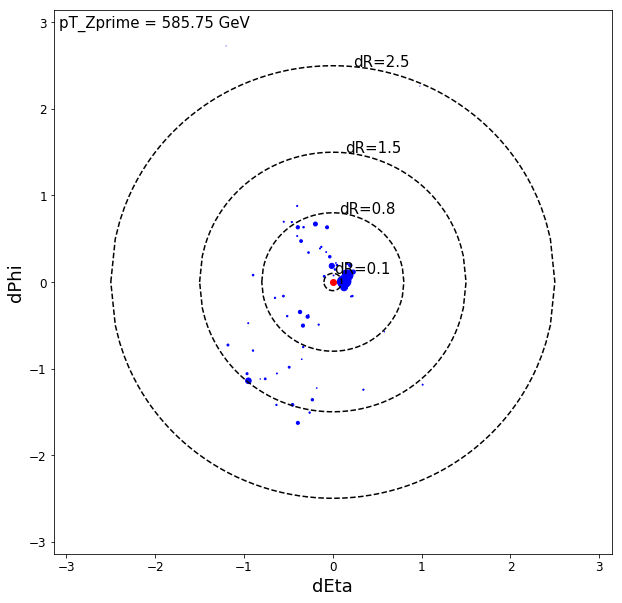

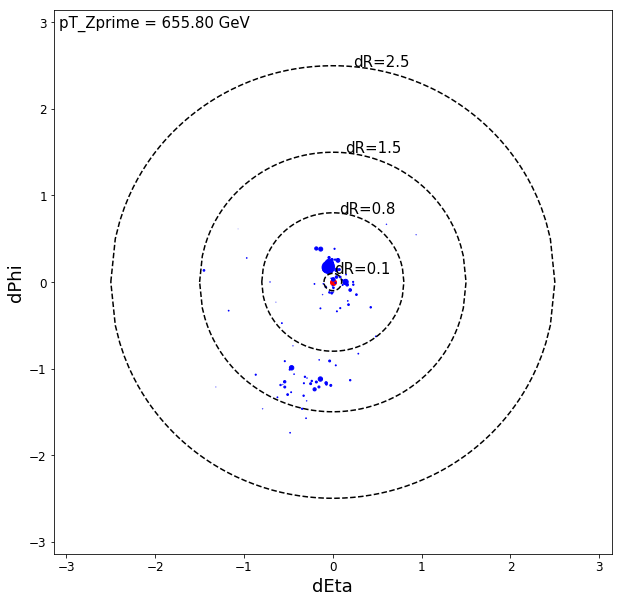

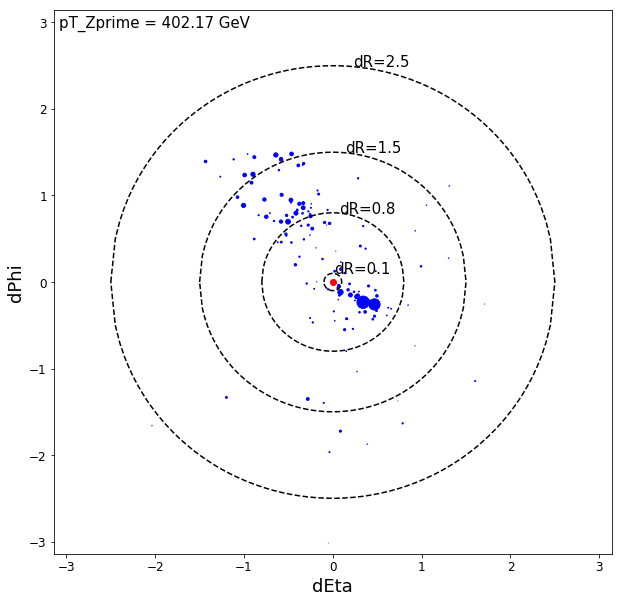

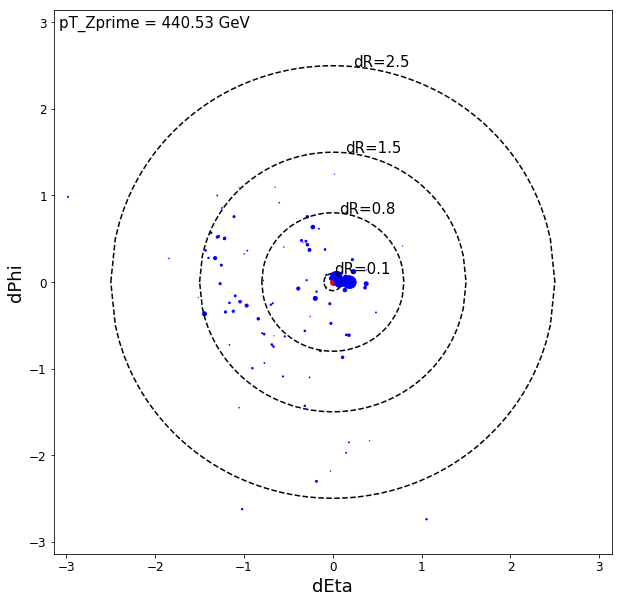

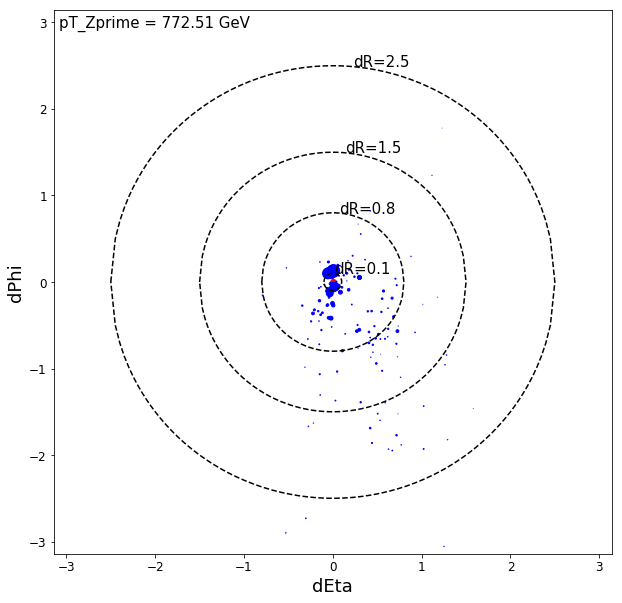

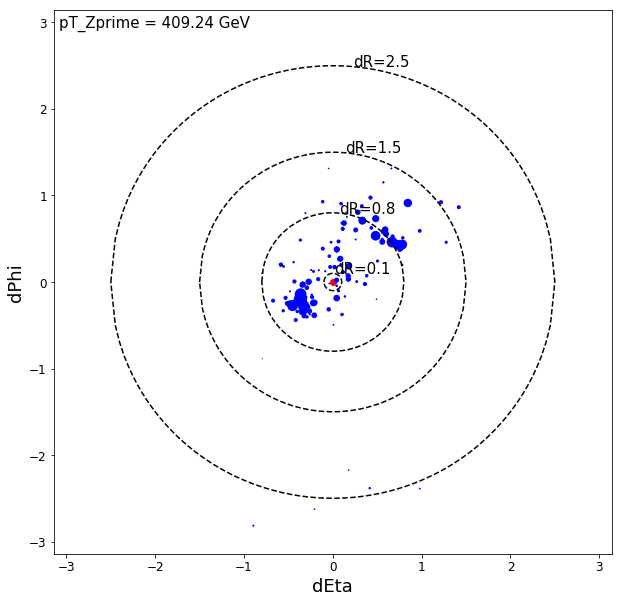

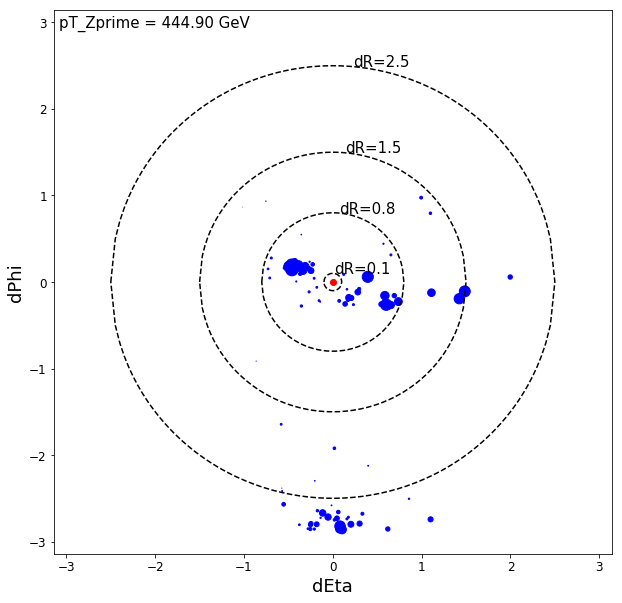

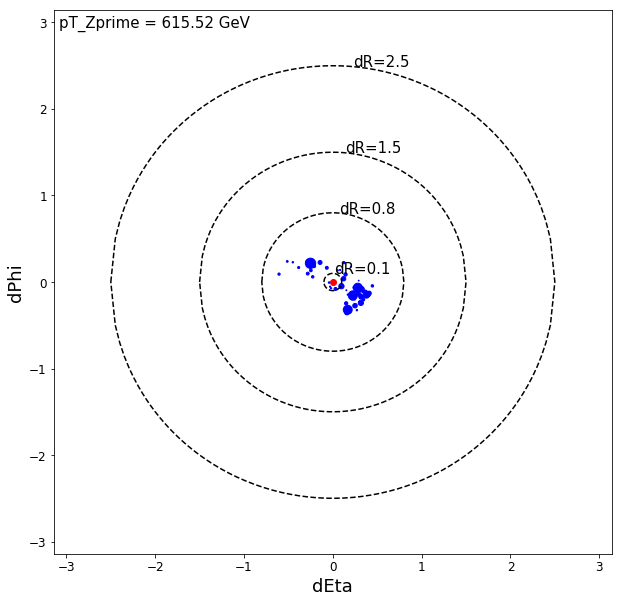

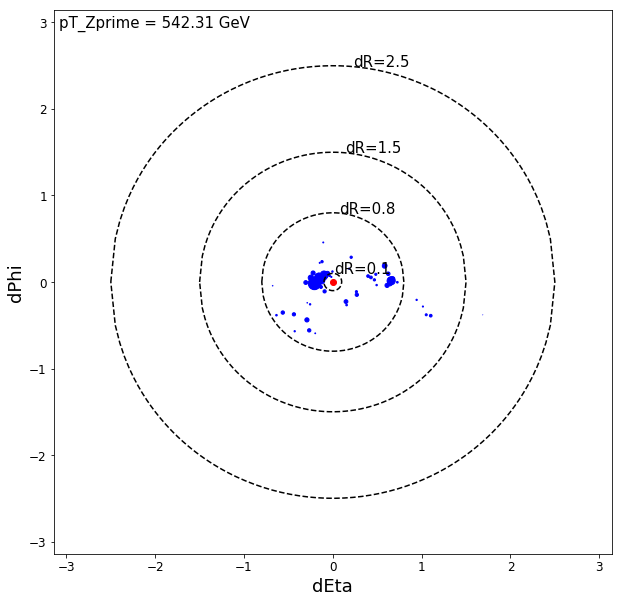

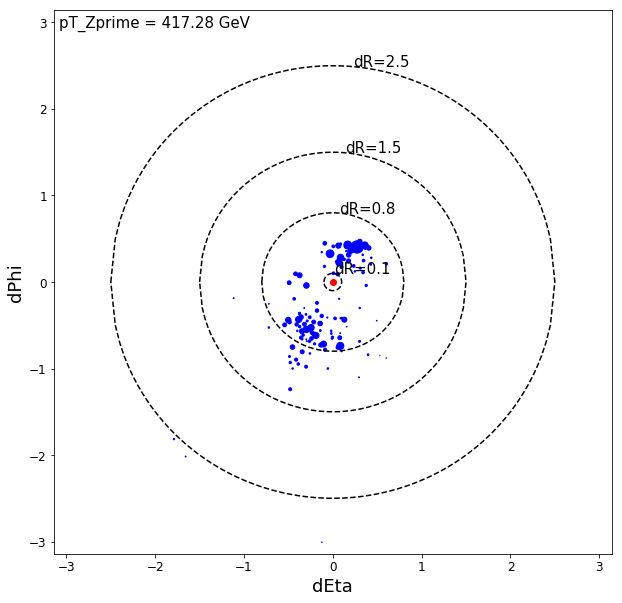

In [4]:
class Plot3DSubPack(object):
    """docstring for Plot3DSubPack"""
    def __init__(self, substructurepack, event):
        super(Plot3DSubPack, self).__init__()
        self.substructurepack = substructurepack
        self.event = event
        self.momscale_x = 1.
        self.momscale_y = 1.
        self.momscale_z = 1.
        
    def set_momscale(self, particle):
        self.momscale_x = particle.p4().Px()
        self.momscale_y = particle.p4().Py()
        self.momscale_z = particle.p4().Pz()
    
    def plot_particle(self, particle, ax, kwargs=None):
        if particle is None:
            raise ValueError('Got particle is None')
        x1 = particle.vx()
        y1 = particle.vy()
        z1 = particle.vz()                
        x2 = x1 + particle.p4().Px() / self.momscale_x
        y2 = y1 + particle.p4().Py() / self.momscale_y
        z2 = z1 + particle.p4().Pz() / self.momscale_z
        # print '({},{},{}) -> ({},{},{})'.format(x1, y1, z1, x2, y2, z2)
        if kwargs is None: kwargs = {}
        ax.plot([x1, x2], [y1, y2], [z1, z2], **kwargs)
        
            
    def plot_3d(self):
        fig = plt.figure(figsize=(15,12))
        ax = fig.gca(projection='3d')
        ax.scatter([0.], [0.], c='k')
        
        self.set_momscale(self.substructurepack.get_zprime())

        self.plot_particle(self.substructurepack.get_zprime(), ax)
        
        for particle in self.event.genparticlesforjets():
            self.plot_particle(particle, ax, kwargs={'color': 'r'})

            
    def get_dr_ring(self, dr, n_points=100):        
        deta = np.linspace(-dr, dr, n_points)
        dphi = np.sqrt(dr**2 - np.square(deta))
        deta = np.concatenate((deta, deta[::-1]))
        dphi = np.concatenate((dphi, -dphi[::-1]))
        return deta, dphi
    
    
    def get_deta_dphi(self, particles, eta_z, phi_z):
        deta_particles = np.zeros(len(particles))
        dphi_particles = np.zeros(len(particles))
        for i, particle in enumerate(particles):
            deta_particles[i] = particle.p4().Eta() - eta_z
            dphi = particle.p4().Phi() - phi_z
            dphi -= int(dphi / (2*pi)) * (2*pi)
            if abs(dphi) > pi: dphi = pi - dphi
            dphi_particles[i] = dphi
        return deta_particles, dphi_particles
                
    def plot_rings(self):
        fig = plt.figure(figsize=(10,10))
        ax = plt.gca()
        
        pt_z = self.substructurepack.get_zprime().p4().Pt()
        eta_z = self.substructurepack.get_zprime().p4().Eta()
        phi_z = self.substructurepack.get_zprime().p4().Phi()
        
        ax.scatter([0.], [0.], c='r')
        
        particles = self.event.genparticlesforjets()
        
        
        deta_particles = np.zeros(len(particles))
        dphi_particles = np.zeros(len(particles))
        for i, particle in enumerate(particles):
            deta_particles[i] = particle.p4().Eta() - eta_z
            dphi = particle.p4().Phi() - phi_z
            dphi -= int(dphi / (2*pi)) * (2*pi)
            if abs(dphi) > pi: dphi = pi - dphi
            dphi_particles[i] = dphi
            
        energies = np.array([ p.energy() for p in particles ])
        e_max = np.max(energies)
        e_normed = 200.*np.tanh(energies/e_max)
        
        ax.scatter([deta_particles], [dphi_particles], c='b', s=(e_normed))
        
        # Make sure z prime is centered
        ax.set_xlim(-pi, pi)
        ax.set_ylim(-pi, pi)
        
        ax.set_xlabel('dEta', fontsize=18)
        ax.set_ylabel('dPhi', fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        for dr in [ 0.1, 0.8, 1.5, 2.5 ]:
            etas, phis = self.get_dr_ring(dr)
            label_index = int(len(etas)*0.27)
            ax.plot(etas, phis, color='k', linestyle='--')
            ax.text(
                etas[label_index], phis[label_index],
                'dR={0:.1f}'.format(dr),
                fontsize=15
                )

        ax.text(
            0.01, 0.99, 'pT_Zprime = {0:.2f} GeV'.format(pt_z),
            verticalalignment='top', horizontalalignment='left',
            transform = ax.transAxes,
            fontsize=15
            )


def plot_some_events(n_events=10):
    n_events_done = 0
    for event in svjconesizestudy.EventFactoryDir.from_sedir(rootdir, 10000):
        for substructurepack in event.substructurepacks():
            if not substructurepack.hasZprime(): continue
            # Apply a cut:
            if substructurepack.get_zprime().p4().Pt() > 400.:
                plot = Plot3DSubPack(substructurepack, event)
                plot.plot_rings()
                n_events_done += 1
                if n_events_done == n_events:
                    return
                
plot_some_events()

In [16]:
logger = svjconesizestudy.logger
logger.setLevel(logging.WARNING)

class EnergyHistogram(svjconesizestudy.Histogram):
    """docstring for EnergyHistogram"""

    # dRbinning = [ 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.5 ]
    dRbinning = list(np.linspace(0., 4., 1000))

    def __init__(self, substructurepack):
        super(EnergyHistogram, self).__init__()
        self.set_binning(self.dRbinning)
        self.substructurepack = substructurepack
        self.genjet_p4 = self.substructurepack.jet().p4()
        self.eta = self.genjet_p4.Eta()
        self.phi = self.genjet_p4.Phi()
        self.fourvectors = [ None for i in range(self.n_bins)]

    def fill_particles(self, particles):
        for particle in particles:
            p4 = particle.p4()
            dR = svjconesizestudy.utils.deltaR(
                self.eta, self.phi,
                p4.Eta(), p4.Phi()
                )
            if dR > self.dRbinning[-1]:
                continue
            else:
                i_bin = self.find_bin(dR)
                if self.fourvectors[i_bin] is None:
                    self.fourvectors[i_bin] = p4
                else:
                    self.fourvectors[i_bin] += p4
        self.y_values = np.array([ v.E() if not(v is None) else 0.0 for v in self.fourvectors ])

    def normalize_by_zprime_energy(self):
        total_energy = self.y_values[-1]
        z_prime_energy = self.substructurepack.get_zprime().energy()
        self.y_values /= z_prime_energy
        logger.debug(
            'Total energy between dR(%0.2f, %0.2f) = %6.2f; '
            'z prime energy = %0.2f (%0.2fx)',
            self.dRbinning[0], self.dRbinning[-1],
            total_energy, z_prime_energy, total_energy / z_prime_energy
            )

    def make_cumulative(self):
        self.y_values = np.zeros(self.n_bins)
        cumul_p4 = None
        for i in range(self.n_bins):
            if cumul_p4 is None:
                cumul_p4 = self.fourvectors[i]
            else:
                if not(self.fourvectors[i] is None):
                    cumul_p4 += self.fourvectors[i]
            self.y_values[i] = cumul_p4.E() if not(cumul_p4 is None) else 0.0

def get_avg_histogram():
    average_energy_ratio_hist = svjconesizestudy.AverageHistogram()
    average_energy_ratio_hist.set_binning(EnergyHistogram.dRbinning)
    n_events = 50000
    for event in tqdm.tqdm(
            svjconesizestudy.EventFactoryDir.from_sedir(rootdir, n_events),
            total = n_events
            ):
        particles = event.genparticlesforjets()
        for substructurepack in event.substructurepacks():
            if not substructurepack.hasZprime(): continue
            # Apply a cut:
            if substructurepack.get_zprime().p4().Pt() > 400.:
                norm_energy_per_dRslice = EnergyHistogram(substructurepack)
                norm_energy_per_dRslice.fill_particles(particles)
                norm_energy_per_dRslice.make_cumulative()
                norm_energy_per_dRslice.normalize_by_zprime_energy()
                average_energy_ratio_hist.sums += norm_energy_per_dRslice.y_values
                average_energy_ratio_hist.counts += 1
    return average_energy_ratio_hist

average_energy_ratio_hist = get_avg_histogram()

[qondor| WARNING|2020-03-10 11:08:13|utils]: Issuing command: xrdfs root://cmseos.fnal.gov/ ls /store/user/klijnsma/semivis/SaveSubstructure/Mar09_35067218_64110319_2020-01-27_GEN_SVJ_s_2017_mZp250_mDQ10_rinv1em05_aD0p23
 50%|█████     | 25000/50000 [06:03<06:03, 68.86it/s] 


Text(0.01,0.99,'pT_Zprime > 400 GeV, N = 60.0')

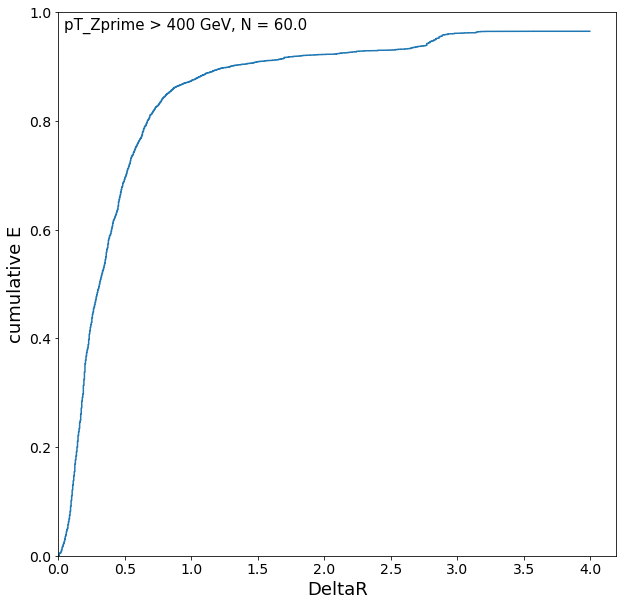

In [19]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xlabel('DeltaR', fontsize=18)
ax.set_ylabel('cumulative E', fontsize=18)

ax.step(
    average_energy_ratio_hist.binning[:-1],
    average_energy_ratio_hist.y_values,
    where = 'post',
    )

ax.set_xlim(0.)
ax.set_ylim(0., 1.0)
ax.tick_params(axis='both', which='major', labelsize=14)

ax.text(
    0.01, 0.99, 'pT_Zprime > 400 GeV, N = {0}'.format(average_energy_ratio_hist.counts[0]),
    verticalalignment='top', horizontalalignment='left',
    transform = ax.transAxes,
    fontsize=15
    )



In [27]:
e_ratio_max = average_energy_ratio_hist.y_values[-1]
for dr in [ 1.5, 2.0, 2.5, 3.0 ]:
    ratio = average_energy_ratio_hist.y_values[average_energy_ratio_hist.find_bin(dr)]
    print('dr = {0:.1f}, e / e_total = {1:.2f}%, e / e_ratio_max = {2:.2f}%'.format(
        dr, 100.*ratio,
        100.*ratio/e_ratio_max
        ))

dr = 1.5, e / e_total = 90.90%, e / e_ratio_max = 94.21%
dr = 2.0, e / e_total = 92.24%, e / e_ratio_max = 95.59%
dr = 2.5, e / e_total = 93.03%, e / e_ratio_max = 96.42%
dr = 3.0, e / e_total = 96.12%, e / e_ratio_max = 99.61%
